# Topic Modeling with Latent Dirichlet Allocation

### Author: Ruchita Nagare


##  Latent "Purposes" in Mobile Apps


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [11]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [12]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [13]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document"

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [14]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

In [15]:
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Part C: Downweight "stopwords"

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()

X_transformed = transformer.fit_transform(X)


### Part D: Discover 10 "topics" 

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [17]:
%%time

num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0, max_iter=10, n_jobs=-1)
lda.fit(X_transformed)
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

CPU times: total: 8.34 s
Wall time: 59.5 s


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic 

In [18]:
num_top_words = 10

def print_top_words(topic_word_distributions, num_top_words):
    vocab = permission_columns
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Your location : coarse (network-based) location (D) : 0.2564494999491137
Your location : fine (GPS) location (D) : 0.24650468420432853
Network communication : full Internet access (D) : 0.15421500176021155
Network communication : view network state (S) : 0.10148873290783794
Phone calls : read phone state and identity (D) : 0.08057643744231588
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.06369555562003527
Services that cost you money : directly call phone numbers (D) : 0.051939345844267217
Your personal information : read sensitive log data (D) : 0.021990441913125706
Network communication : view Wi-Fi state (S) : 0.01956235591457967
Default : access checkin properties (S) : 0.0009866530013707695

[Topic 1]
Hardware controls : control vibrator (S) : 0.44428245980772507
Network communication : full Internet access (D) : 0.14349279845405583
Network communicati

***Some topics from the above 10 do seem to have coherence, while some have word intrusions. According to my inference topics that make sense are as follows:***

***Topic 3: The permissions in this topic seem focused on dealing with known/unknown applications or accounts.***

***Topic 4: This topic relates to phone state(sleep, boot) and UI.***

***Topic 7: This topic seems like permissions which are related to wireless connectivity like wifi, bluetooth.***

***Topic 9: This topics looks like the ones which correponding to acessing personal communication data like contacts, messages, phone calls.***

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic 

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [19]:
doc_topic_matrix = lda.transform(X_transformed)

def top_3(doc_topic_matrix):
    for topic in range(num_topics):
        sort_indices = np.argsort(-doc_topic_matrix[:, topic])
        sort_indices = [i for i in sort_indices if app_ratings[i]>=100000]
        print("Topic", topic, ":")
        for x in sort_indices[:3]:
            print(app_names[x])
        print()
        
print("Top 3 apps with at least 100000 for each topic")
print()
top_3(doc_topic_matrix)

Top 3 apps with at least 100000 for each topic

Topic 0 :
Air Control Lite
Dictionary.com
Paper Toss

Topic 1 :
Vaulty Free Hides Pictures
Live Holdem Poker Pro
Drag Racing

Topic 2 :
Yoo Ninja! Free
Angry Birds Seasons
Adobe Reader

Topic 3 :
Lookout Security & Antivirus
Antivirus Free
Skype

Topic 4 :
Real BlackJack
Alchemy
Tank Hero

Topic 5 :
World Newspapers
Paradise Island
My Country

Topic 6 :
Brightest Flashlight Free™
Brightest Flashlight Free???
Tiny Flashlight + LED

Topic 7 :
Slice It!
Racing Moto
Blast Monkeys

Topic 8 :
TuneIn Radio
Restaurant Story???
Restaurant Story™

Topic 9 :
chompSMS
Ringdroid
Google Sky Map



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

[t-SNE] Computing 2281 nearest neighbors...
[t-SNE] Indexed 6500 samples in 0.012s...
[t-SNE] Computed neighbors for 6500 samples in 4.859s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6500
[t-SNE] Computed conditional probabilities for sample 2000 / 6500
[t-SNE] Computed conditional probabilities for sample 3000 / 6500
[t-SNE] Computed conditional probabilities for sample 4000 / 6500
[t-SNE] Computed conditional probabilities for sample 5000 / 6500
[t-SNE] Computed conditional probabilities for sample 6000 / 6500
[t-SNE] Computed conditional probabilities for sample 6500 / 6500
[t-SNE] Mean sigma: 0.131071


C:\Users\ruchi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.137722
[t-SNE] KL divergence after 2000 iterations: -0.083751


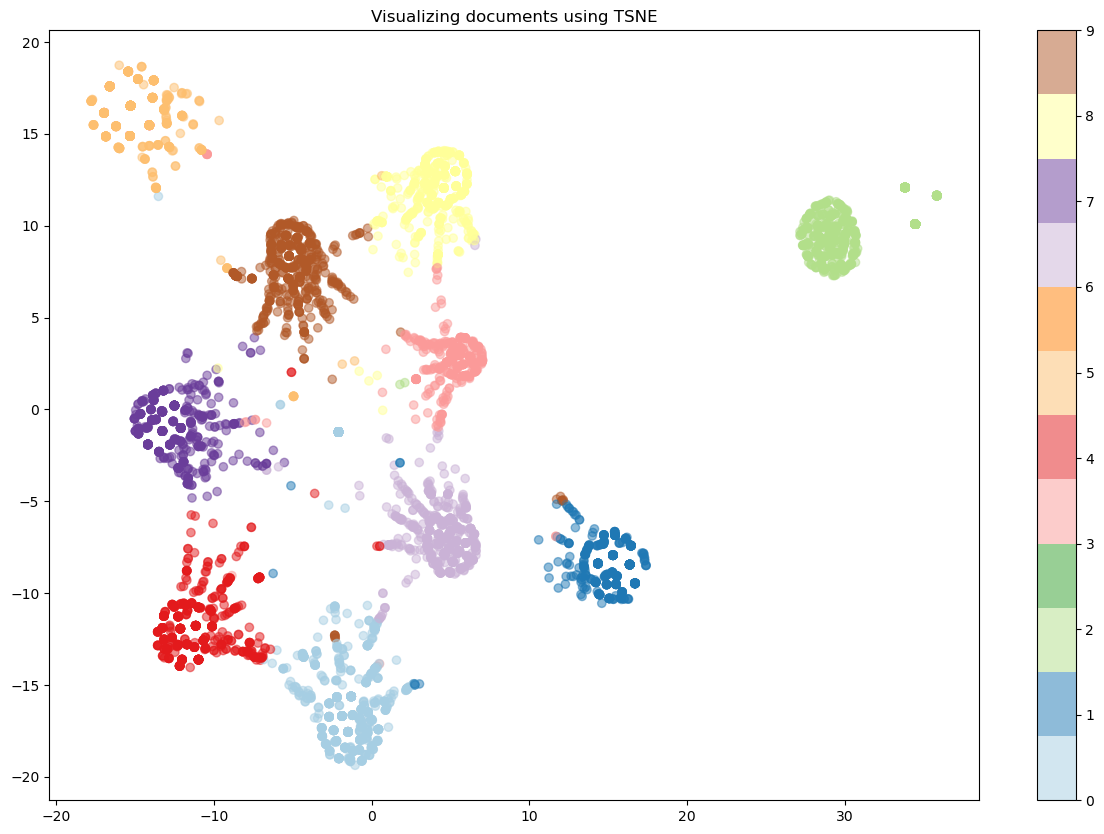

CPU times: total: 26min 12s
Wall time: 6min 12s


In [20]:
%%time

from sklearn.manifold import TSNE

sorted_topics = doc_topic_matrix.argmax(axis = 1)[0:6500]
tsne = TSNE(n_components=2,
            angle=0.99,
            init='pca',
            random_state=0,
            perplexity=760,
            verbose=1,
            learning_rate=320,
            n_iter=2000)

feature_vectors_tsne2d = tsne.fit_transform(doc_topic_matrix[0:6500])

#Plotting the t-SNE dimensions as a scatterplot.
plt.figure(figsize=(15,10))
plt.scatter(feature_vectors_tsne2d[:,0], feature_vectors_tsne2d[:,1], c=sorted_topics, cmap='Paired', alpha=0.5)
plt.colorbar()
plt.title('Visualizing documents using TSNE')
# plt.legend()
plt.show()